# Задание 

# 🥨👨🏻‍🍳🥐🥖 

Мы хотим усилить визуальный контент. Есть идея, что если мы сделаем не одну картинку, а еще и добавим видео производства наших изделий, то пользователь будет принимать решение о покупке охотнее и быстрее, и конверсия в заказ вырастет. 

__Продакт вернул нам такой дизайн эксперимента:__

*1. `Бизнес-проблема:`* мы считаем, что конверсии из визита в покупку в нашем магазине недостаточно высоки. Мы посмотрели на страницы конкурентов и поняли, что у нас есть возможность увеличить объем продаж, если мы еще немного изменим дизайн страницы с каталогом продукции. 

*2. `Гипотеза:`* предполагается, что добавление видео с процессом приготовления вкусностей мотивирует к их покупке и позволяет добиться двух эффектов:
   * повышение конверсии из визита в оплату (больше людей захотят купить нашу продукцию)
   * как минимум, не снижение среднего чека покупки, а в идеале — увеличение
    
*3. `Ожидаемые действия пользователей:`* мы ожидаем, что, увидев видео с процессом приготовления вкусностей вместе с описанием продукции, больше людей захотят сделать покупку, а возможно — в среднем будут покупать больше продукции в одном заказе.

*4. `Эксперимент будет считаться успешным, если:`*
   * конверсия из визита в покупку с окном в 7 дней повысится
   * средний чек покупки не снизится


## Что нужно сделать?

Проанализировать данные нового теста и дать свои комментарии о его успешности. Можно ли выкатывать изменение на всех пользователей?

1. Выбрать окно конверсии.
2. Исследовать распределение пользователей по группам по основным сегментам
3. Оценить статистическую значимость в изменении конверсии с помощью критерия хи-квадрат
4. Вычислить мощность теста
5. Использовать бутстрап для оценки влияния теста на средний чек
6. Сделать вывод по результатам проведенного теста 

## Задание 1. Выбор окна конверсии, используя исторические данные 

**1. Прочитаем файл investigate_window.csv.**
   - Запишем даннные в переменную `historical_data`
    
   - Отправим безымянную колонку с нумерацией в индекс с помощью аргумента функции `read_csv()`.
   
   - Проверим, какой тип данных в каждой колонке, и переведем столбцы с датами в формат даты. 

In [2]:
import pandas as pd

In [3]:
historical_data = pd.read_csv('investigate_window.csv',
                             parse_dates = [1,2], index_col = 0)

In [4]:
historical_data.head()

,user_id,main_page_viewed_at,order_completed_at,time_to_order
0,959238,2020-11-20 23:55:02.759000+00:00,2020-11-30 02:22:32.759000+00:00,9.102431
1,337366,2020-12-05 23:41:42.244000+00:00,2020-12-12 22:25:52.244000+00:00,6.947338
2,259956,2020-11-20 23:33:53.269000+00:00,2020-11-25 13:08:03.269000+00:00,4.565394
3,534280,2020-11-28 23:44:56.556000+00:00,2020-12-05 10:14:06.556000+00:00,6.436921
4,795121,2020-11-18 23:59:56.236000+00:00,2020-11-27 02:38:16.236000+00:00,8.109954


In [5]:
historical_data.dtypes # Проверяем, выводятся ли даты в формате datetime?

user_id                             object
main_page_viewed_at    datetime64[ns, UTC]
order_completed_at                  object
time_to_order                      float64
dtype: object

**2. Вычисляем 95, 90 и 85 перцентили для наших данных с помощью колонки time_to_order.**

In [6]:
import numpy as np #   - Используем функцию перцентиля из библиотеки.

In [7]:
np.percentile(historical_data['time_to_order'], 95)

7.117476851851854

In [8]:
np.percentile(historical_data['time_to_order'], 90)

2.864949845679016

In [9]:
np.percentile(historical_data['time_to_order'], 85)

1.9903886959876524

In [10]:
perc_85 = round(np.percentile(historical_data['time_to_order'], 85), 1)
perc_85 # Недельное окно конверсии

2.0

**3. Строим гистограмму распределения времени между первым заходом на сайт и покупкой.** 

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt

C:\Users\ekate\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


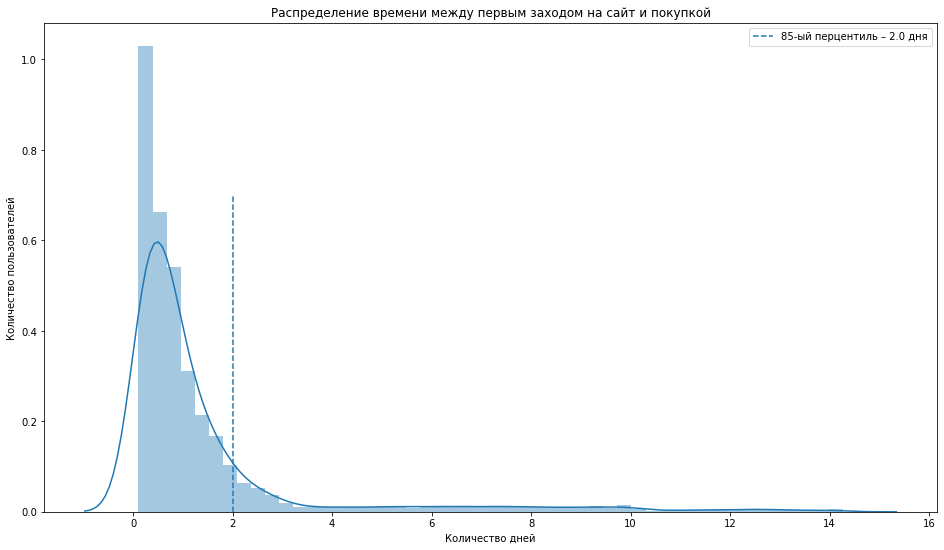

In [15]:
plt.figure(figsize=(16,9))
sns.distplot(historical_data['time_to_order'])
plt.vlines(perc_85,
           ymin = 0,
           ymax = 0.7,
           linestyles = 'dashed',
           label = f'85-ый перцентиль – {perc_85} дня')
plt.title('Распределение времени между первым заходом на сайт и покупкой')
plt.xlabel('Количество дней')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

**4. Делаем вывод об окне конверсии.** 

Так как 85% пользователей делают заказ именно в этот период, возьмем 2 дня в качестве окна для конверсии

## Задание 2. Исследовать распределение пользователей по группам по основным сегментам 

**1. Подключаем к данным А/В теста, прочитаем файл bakery_ab_test.csv.**

In [16]:
data = pd.read_csv('bakery_ab_test.csv', index_col = 0) #Запишем данные в переменную `data`. 
data.head()

,user_id,test_group,purchase_amount,geo_group,acquisition_channel,within_window,platform
1,3738,test,306.639511,regions,target_direct,1,pc
2,3755,control,NaN,regions,target_direct,0,pc
3,3772,test,NaN,regions,context_brand,0,mobile
4,3789,control,NaN,spb,target_direct,0,pc
5,3806,test,NaN,regions,social_media,0,pc


In [17]:
metrics = data.groupby('test_group', as_index= False).agg({'user_id': 'count', 'within_window': 'sum'})
metrics['conversion'] = round(metrics['within_window']/metrics['user_id']*100, 2)
metrics

,test_group,user_id,within_window,conversion
0,control,75210,22998,30.58
1,test,75273,24427,32.45


**2. Напишем функцию `plot_segment_distribution`, чтобы проверить распределение пользователей по сегментам внутри каждой группы.**

In [22]:
def plot_segment_distribution(df, segment_columns, test_factor):
    for segment in segment_columns:
        aggregated_data = df.groupby(by = [test_factor, segment])['user_id'].count().reset_index()
        sns.catplot(x = segment, 
                    y = 'user_id', 
                    hue = test_factor, # сообщаем, что хотим, чтобы разные группы имели разный цвет
                    data = aggregated_data, 
                    kind = "bar", 
                    height = 4, # задаем размер графика 
                    aspect = 1.5) # задаем ширину столбца
    

**3. Строим графики при помощи созданой функции.**

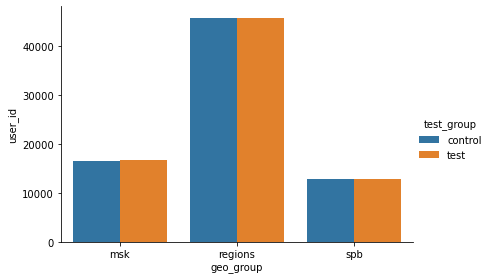

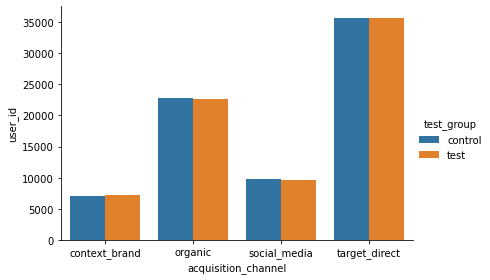

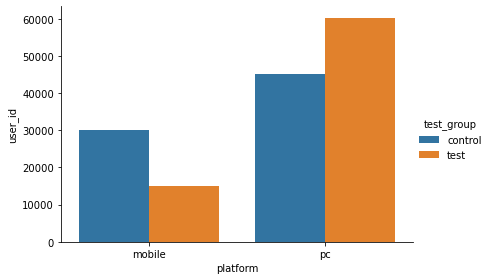

In [24]:
plot_segment_distribution(data, #датафрейм
                           ["geo_group", "acquisition_channel", "platform"], #сегменты
                           "test_group") #тест-фактор

**4. Делаем вывод о качестве сплитования.** 

В рамках сегментов geo_group и acquisition_channel группы распределены равномерно.

В рамках сегмента platform распределение неравномерное.

## Задание 3. Используем критерий Хи-квадрат для конверсии


Мы не можем исправить данные, но можем проанализировать общие результаты и сравнить их с результатами для пользователей, зашедших с разных платформ, чтобы уменьшить риск принятия ошибочного решения. 
Поэтому дальше мы будем анализировать параллельно 3 теста:

1. Все пользователи, попавшие в тест
2. Пользователи, заходившие с ПК `platform = 'pc'`
3. Пользователи, заходившие с мобильного `platform = 'mobile'`

**1. Для каждой из 3 групп теста сделаем отдельную таблицу с метриками**
   - общее количество пользователей 'user_id': 'count'
   - количество покупок в окне конверсии 'within_window': 'sum'
   - средняя сумма покупки 'purchase_amount': 'mean'
   - конверсия (количество покупок в окне конверсии / общее количество пользователей или среднее по полю `within_window`)

In [25]:
data = pd.read_csv('bakery_ab_test.csv', index_col = 0)
data.head()

,user_id,test_group,purchase_amount,geo_group,acquisition_channel,within_window,platform
1,3738,test,306.639511,regions,target_direct,1,pc
2,3755,control,NaN,regions,target_direct,0,pc
3,3772,test,NaN,regions,context_brand,0,mobile
4,3789,control,NaN,spb,target_direct,0,pc
5,3806,test,NaN,regions,social_media,0,pc


In [26]:
metrics = data.groupby('test_group', as_index= False).agg({'user_id': 'count', 'within_window': 'sum','purchase_amount':'mean'})
metrics['conversion'] = round(metrics['within_window']/metrics['user_id']*100, 2)
metrics

,test_group,user_id,within_window,purchase_amount,conversion
0,control,75210,22998,5170.864335,30.58
1,test,75273,24427,5394.771589,32.45


In [27]:
metrics_pc = data[data['platform']== 'pc'].groupby('test_group', as_index= False).agg({'user_id': 'count', 'within_window': 'sum','purchase_amount':'mean'})
metrics_pc['conversion'] = round(metrics['within_window']/metrics['user_id']*100, 2)
metrics_pc

,test_group,user_id,within_window,purchase_amount,conversion
0,control,45112,13732,5200.121803,30.58
1,test,60317,19659,5401.003720,32.45


In [28]:
metrics_mobile = data[data['platform']== 'mobile'].groupby('test_group', as_index= False).agg({'user_id': 'count', 'within_window': 'sum','purchase_amount':'mean'})
metrics_mobile['conversion'] = round(metrics['within_window']/metrics['user_id']*100, 2)
metrics_mobile 

,test_group,user_id,within_window,purchase_amount,conversion
0,control,30098,9266,5127.505438,30.58
1,test,14956,4768,5369.075812,32.45


**2. Вычислием** `p-value` **для каждой группы с помощью теста хи-квадрат**

In [29]:
import statsmodels.stats.proportion as proportion

In [30]:
chi2stat, pval, table = proportion.proportions_chisquare(metrics['within_window'], metrics['user_id'])
pval

5.321539863368111e-15

In [31]:
chi2stat_pc, pval_pc, table_pc = proportion.proportions_chisquare(metrics['within_window'], metrics_pc['user_id'])
pval_pc

3.60911339167226e-251

In [32]:
chi2stat_mobile, pval_mobile, table_mobile = proportion.proportions_chisquare(metrics['within_window'], metrics_mobile['user_id'])
pval_mobile

1.0

**3. Вводим в анализ уровень значимости в 5% с помощью переменной** `alpha`.

In [33]:
alpha = 0.05

**3. Оставим комментарий, какой вывод о наличии статистически значимой в каждой группе разницы можно сделать? Что делаем с нулевой гипотезой?**

In [34]:
print('p-value меньше, чем уровень значимости для всех наблюдений?', pval < alpha)
print('p-value меньше, чем уровень значимости для PC?', pval_pc < alpha)
print('p-value меньше, чем уровень значимости для Mobile?', pval_mobile < alpha)

p-value меньше, чем уровень значимости для всех наблюдений? True
p-value меньше, чем уровень значимости для PC? True
p-value меньше, чем уровень значимости для Mobile? False


## Задание 4. Вычисляем мощность теста

1. Импортируем объект `stats.power` из библиотеки `statsmodels`
2. Присвоим функцию `GofChisquarePower()` из этой библиотеки в переменную `chipower` 
3. Реализуем функцию для подсчета `effect_size`

In [35]:
import statsmodels.stats.power as smp

In [36]:
chipower = smp.GofChisquarePower()

`effect_size` — это та самая наблюдаемая разница между двумя вариантами. Вычисляется следующим образом: 

$$ES = \sqrt{(p_0 - p_1)^2/p_o}$$

, где под $p_0$ можно понимать конверсию в контрольной группе, а $p_1$ — тестовой

In [37]:
def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

**1. Запишем значения конверсии в тестовой `conversion_test` и контрольной `conversion_control` группы в разные переменные.
Создаем переменную `nobs` для количества наблюдений и запишем в нее значение меньшей группы**

In [38]:
conversion_control = metrics['conversion'].values[0]/100
conversion_test=metrics['conversion'].values[1]/100
nobs=min(metrics['user_id'])
nobs

75210

In [39]:
conversion_control_mobile = metrics_mobile['conversion'].values[0]/100
conversion_test_mobile = metrics_mobile['conversion'].values[1]/100
nobs_mobile = min(metrics_mobile['user_id'])
nobs_mobile

14956

In [40]:
conversion_control_pc = metrics_pc['conversion'].values[0]/100
conversion_test_pc = metrics_pc['conversion'].values[1]/100
nobs_pc = min(metrics_pc['user_id'])
nobs_pc

45112

**6. Вызовем функцию `.solve_power` для того, чтобы посчитать, на сколько одна группа эффективнее другой в исследуемой метрике.** 

In [41]:
def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

**7. Сделаем анализ мощности для каждого сегмента, для которого делали тест хи-квадрат.**

In [42]:
power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_test), # разница коэффициентов конверсии
                            nobs = nobs, # размер выборки
                            alpha = pval, # значение ошибки первого рода на наших данных
                            power = None) # функция вернет значение, указаное как None
power

0.9271367916086642

In [43]:
mobile_power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control_mobile, conversion_test_mobile), # разница коэффициентов конверсии
                            nobs = nobs_mobile, # размер выборки
                            alpha = pval_mobile, # значение ошибки первого рода на наших данных
                            power = None) # функция вернет значение, указаное как None
mobile_power

1.0

In [44]:
pc_power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control_pc, conversion_test_pc), # разница коэффициентов конверсии
                            nobs = nobs_pc, # размер выборки
                            alpha = pval_pc, # значение ошибки первого рода на наших данных
                            power = None) # функция вернет значение, указаное как None
pc_power

2.3314683517128287e-15

## Задание 5. Воспользумся бутстрапом для оценки влияния теста на средний чек

**1. Записываем данные по суммам покупки в тестовой и контрольной группе в разные переменные.**

In [45]:
test = data[data['test_group'] == 'test']['purchase_amount'].dropna().values
control = data[data['test_group'] == 'control']['purchase_amount'].dropna().values

test_pc = data[(data['test_group'] == 'test') & (data['platform'] == 'pc')]['purchase_amount'].dropna().values
control_pc =  data[(data['test_group'] == 'control') & (data['platform'] == 'pc')]['purchase_amount'].dropna().values

test_mobile = data[(data['test_group'] == 'test') & (data['platform'] == 'mobile')]['purchase_amount'].dropna().values
control_mobile =  data[(data['test_group'] == 'control') & (data['platform'] == 'mobile')]['purchase_amount'].dropna().values

**2. Вызовем функцию `bootstrap_ab` для каждого сегмента, передадим ей нужные аргументы**
   - `test = `
   - `ctrl = `
   - `stat_func = bs_stats.mean`
   - `compare_func = bs_compare.difference`
   - `return_distribution = True`

In [46]:
# импортируем необходимые модули
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import numpy as np

In [50]:
boot = bs.bootstrap_ab(test = test, ctrl = control
                              , stat_func = bs_stats.mean #получим средние значения из выборок
                              , compare_func = bs_compare.difference #получим разницу между значениями в двух группах
                              , return_distribution=True) #вернем значение каждой итерации, чтобы в будущем что-то сделать с расчетами функции
boot

array([162.75607623, 223.63340477, 216.6718228 , ..., 231.38279982,
       195.5620429 , 220.43751658])

In [51]:
boot_pc = bs.bootstrap_ab(test = test_pc, ctrl = control_pc
                              , stat_func = bs_stats.mean #получим средние значения из выборок
                              , compare_func = bs_compare.difference #получим разницу между значениями в двух группах
                              , return_distribution=True) #вернем значение каждой итерации, чтобы в будущем что-то сделать с расчетами функции
boot_pc

array([275.96802964, 183.4597982 , 171.97384941, ..., 158.38007342,
       177.58003074, 160.31790301])

In [49]:
boot_mobile = bs.bootstrap_ab(test = test_mobile , ctrl = control_mobile 
                              , stat_func = bs_stats.mean #получим средние значения из выборок
                              , compare_func = bs_compare.difference #получим разницу между значениями в двух группах
                              , return_distribution=True)#вернем значение каждой итерации, чтобы в будущем что-то сделать с расчетами функции
boot_mobile

array([226.10940537, 254.71817398, 185.14495798, ..., 374.82112109,
       223.40404602, 411.06826251])

**3. Зададим размер доверительного интервала для каждого исследуемого сегмента 95% с помощью перцентилей**

In [53]:
borders = np.percentile(boot, [2.5, 97.5]) # считаем перцентили
borders_pc = np.percentile(boot_pc, [2.5, 97.5])
borders_mobile = np.percentile(boot_mobile, [2.5, 97.5])

**4. Оценим, есть ли статистически значимое изменение по среднему чеку в каждом сегменте**

C:\Users\ekate\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


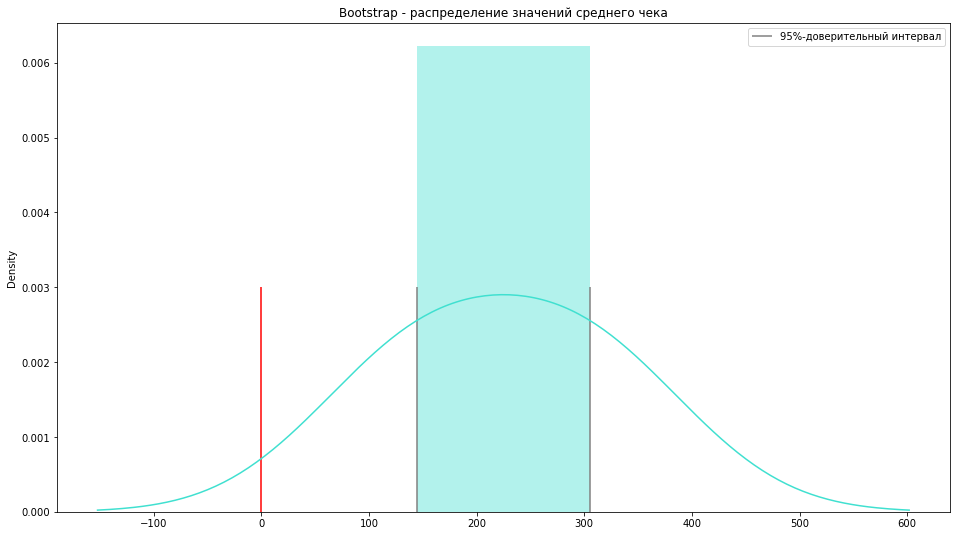

In [56]:
plt.figure(figsize=(16,9))
sns.distplot(borders, color='turquoise')
plt.vlines(0,
           ymin = 0, 
           ymax = 0.003,
          colors = 'red')
plt.vlines(borders,
           ymin = 0, 
           ymax = 0.003,
          colors = 'grey',
          label= '95%-доверительный интервал')
plt.title('Bootstrap - распределение значений среднего чека')
plt.legend()
plt.show()

C:\Users\ekate\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


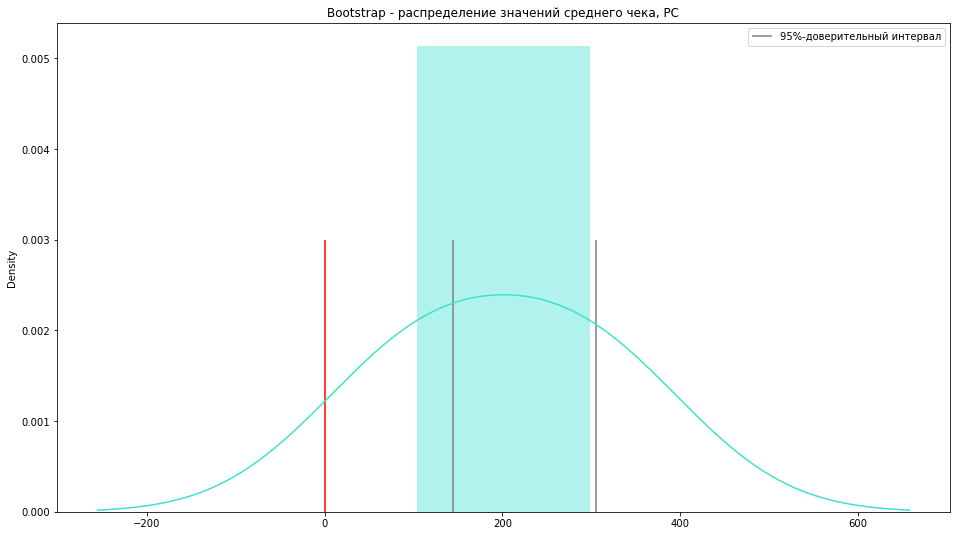

In [57]:
plt.figure(figsize=(16,9))
sns.distplot(borders_pc, color='turquoise')
plt.vlines(0,
           ymin = 0, 
           ymax = 0.003,
          colors = 'red')
plt.vlines(borders,
           ymin = 0, 
           ymax = 0.003,
          colors = 'grey',
          label= '95%-доверительный интервал')
plt.title('Bootstrap - распределение значений среднего чека, PC')
plt.legend()
plt.show()

C:\Users\ekate\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


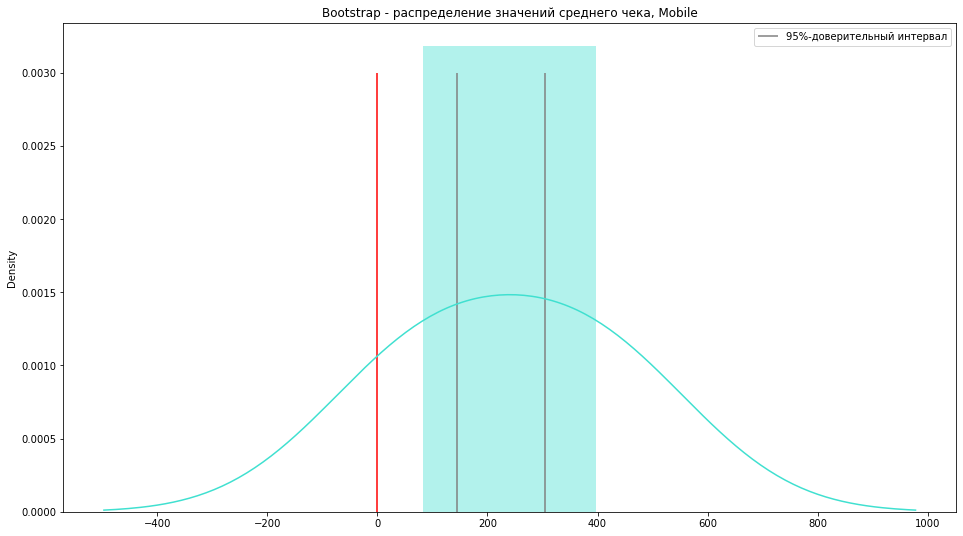

In [58]:
plt.figure(figsize=(16,9))
sns.distplot(borders_mobile, color='turquoise')
plt.vlines(0,
           ymin = 0, 
           ymax = 0.003,
          colors = 'red')
plt.vlines(borders,
           ymin = 0, 
           ymax = 0.003,
          colors = 'grey',
          label= '95%-доверительный интервал')
plt.title('Bootstrap - распределение значений среднего чека, Mobile')
plt.legend()
plt.show()

**5. Делаем вывод о том, есть ли статистически значимое изменен е среднего чека в каждой группе.**

Во всех трех случаях ноль не входит в доверительный интервал, значит есть статистически значимое изменение среднего чека. Во всех трех случаях средний чек увеличился.

## Задание 6. Вывод по результатам проведенного теста

Значимое различие в конверсии у нас есть и так же оно есть в среднем чеке, соответсвенно мы можем нулевую гипотезу опровергнуть и принять альтернативную гипотезу.

Соответсвенно наш новый вариант сайта значительно лучше и он привлекает клиентов.

## Ответ куратора на домашнее задание:
Получила правильный результат и написала вывод, молодец! Домашка принята :)


# 🎉🎉🎉 Поздравляем, ты великолепен! 